In [2]:
import numpy as np
import json

In [3]:
with open('points_table.json') as f:
    points_table = json.load(f)

def time_to_secs(time):
    if time == '-':
        return np.nan
    denoms = time.split(':')
    factors = 60 ** np.arange(len(denoms))[::-1]
    return round(np.sum([float(denom) * factor for denom, factor in zip(denoms, factors)]),2)

points_table['Women'].keys()

dict_keys(['100m', '200m', '300m', '400m', '500m', '100mH', '400mH', '4x100m', '4x200m', '4x400m', '600m', '800m', '1000m', '1500m', 'Mile', '2000m', '2000mSC', '3000m', '3000mSC', '2 Miles', '5000m', '10,000m', '5km', '10km', '15km', '10 Miles', '20km', 'HM', '25km', '30km', 'Marathon', '100km', '3kmW', '5kmW', '10kmW', '15kmW', '20kmW', '30kmW', '35kmW', '50kmW', '3000mW', '5000mW', '10,000mW', '15,000mW', '20,000mW', '30,000mW', '35,000mW', '50,000mW', 'HJ', 'PV', 'LJ', 'TJ', 'SP', 'DT', 'HT', 'JT', 'Heptathlon'])

In [4]:
# categorize events
track_events = ['100m', '200m', '300m', '400m', '500m', '600m', '800m', '1000m', '1500m', 'Mile', '2000m', '3000m', '2 Miles', '5000m', '10,000m']
road_events = ['5km', '10km', '15km', '10 Miles', '20km', 'HM', '25km', '30km', 'Marathon', '100km']
hurdle_events = ['100mH', '110mH', '400mH', '2000mSC', '3000mSC']
track_walk_events = ['3000mW', '5000mW', '10,000mW', '15,000mW', '20,000mW', '30,000mW', '35,000mW', '50,000mW']
road_walk_events = ['3kmW', '5kmW', '10kmW', '15kmW', '20kmW', '30kmW', '35kmW', '50kmW']
relay_events = ['4x100m', '4x200m', '4x400m']
field_events = ['HJ', 'PV', 'LJ', 'TJ', 'SP', 'DT', 'HT', 'JT']
combined_events = ['Heptathlon', 'Decathlon']

# map distances to events
mile_to_km = 1.60934
marathon_to_km = 42.195
distance_map = {'100m':0.1,
                '200m':0.2, 
                '300m':0.3, 
                '400m':0.4, 
                '500m':0.5, 
                '600m':0.6, 
                '800m':0.8, 
                '1000m':1, 
                '1500m':1.5, 
                'Mile':mile_to_km, 
                '2000m':2, 
                '3000m':3, 
                '2 Miles':2*mile_to_km, 
                '5000m':5, 
                '10,000m':10,
                '5km':5,
                '10km':10,
                '15km':15,
                '10 Miles':10*mile_to_km,
                '20km':20,
                'HM':0.5*marathon_to_km,
                '25km':25,
                '30km':30,
                'Marathon':marathon_to_km,
                '100km':100,
                '100mH':0.1,
                '110mH':0.11,
                '400mH':0.4,
                '2000mSC':2,
                '3000mSC':3,
                '3000mW':3,
                '5000mW':5,
                '10,000mW':10,
                '15,000mW':15,
                '20,000mW':20,
                '30,000mW':30,
                '35,000mW':35,
                '50,000mW':50,
                '3kmW':3,
                '5kmW':5,
                '10kmW':10,
                '15kmW':15,
                '20kmW':20,
                '30kmW':30,
                '35kmW':35,
                '50kmW':50,
                '4x100m':0.4,
                '4x200m':0.8,
                '4x400m':1.6,
                }

restructured_points_table = {'Points':[int(x) for x in points_table['Points']], 'Men':{}, 'Women':{}}
for gender in ['Men', 'Women']:
    for category in ['Track', 'Road', 'Hurdle', 'Track_Walk', 'Road_Walk', 'Relay', 'Field', 'Combined']:
        restructured_points_table[gender][category] = {}
        for event in eval(category.lower() + '_events'):
            if event in points_table[gender].keys():
                restructured_points_table[gender][category][event] = {}
                if category in ['Field', 'Combined']:
                    restructured_points_table[gender][category][event]['Data'] = [np.nan if x == '-' else float(x) for x in points_table[gender][event]]
                else:
                    restructured_points_table[gender][category][event]['Data'] = [time_to_secs(x) for x in points_table[gender][event]]
                    restructured_points_table[gender][category][event]['Distance'] = distance_map[event]
                mask = [not np.isnan(x) for x in restructured_points_table[gender][category][event]['Data']]
                filtered_data = np.array(restructured_points_table[gender][category][event]['Data'])[mask]
                filtered_points = np.array(restructured_points_table['Points'])[mask]
                fit_data = np.polyfit(filtered_data, filtered_points, 2)
                restructured_points_table[gender][category][event]['Fit'] = fit_data

Select data

In [5]:
# input data
gender = 'Men'
category = 'Track_Walk'
event = '15,000mW'
time = '1:07:24.03'

# compute points
seconds = time_to_secs(time)
points = np.polyval(restructured_points_table[gender][category][event]['Fit'], seconds)
print(points)

957.9870741086816


Ideas of potential features:
- Interpolate the running event data
- Extrapolate and interpolate the walks data
- Account for all weights in the throws by using a factor of $\frac{1}{m}$
- Automatically account for wind in the jumps and sprints
- Account for the elevation in the road events
- Account for hand timing
- Explore relationship between relays and individual events
- See what events are in the indoor list but not in the outdoor list

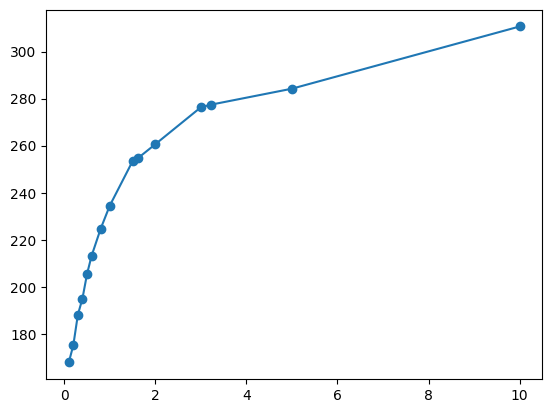

In [33]:
import matplotlib.pyplot as plt

gender = 'Men'

distance_data = []
time_data = []
for event in restructured_points_table[gender]['Track'].keys():
    distance_data.append(restructured_points_table[gender]['Track'][event]['Distance'])
    time_data.append(restructured_points_table[gender]['Track'][event]['Data'][-1])

pace_data = [time_data[x]/distance_data[x] for x in range(len(time_data))]
start = 0
end = 15
plt.scatter(distance_data[start:end], pace_data[start:end])
plt.plot(distance_data[start:end], pace_data[start:end])
plt.show()